<a href="https://colab.research.google.com/github/nathaliedees/thesis/blob/master/cnn_orthophotomosaic_test_good.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal
from PIL import Image as Img
from PIL import ImageTk

import os
import sklearn.preprocessing as skl


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/'My Drive'/Master/Data

/content/drive/My Drive/Master/Data


In [4]:
CUDA_LAUNCH_BLOCKING=1

In [5]:
%ls

aug/


In [6]:
%matplotlib inline
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
# etc, etc, etc

path=Path('/content/drive/My Drive/Master/Data/aug')

In [7]:
path.ls()

[PosixPath('/content/drive/My Drive/Master/Data/aug/test'),
 PosixPath('/content/drive/My Drive/Master/Data/aug/results'),
 PosixPath('/content/drive/My Drive/Master/Data/aug/backup'),
 PosixPath('/content/drive/My Drive/Master/Data/aug/trainAnnotate'),
 PosixPath('/content/drive/My Drive/Master/Data/aug/trainData')]

In [8]:
#import training images
fnames = get_image_files(path/'trainData')
fnames[:5]

[PosixPath('/content/drive/My Drive/Master/Data/aug/trainData/augmented_1.png'),
 PosixPath('/content/drive/My Drive/Master/Data/aug/trainData/augmented_4.png'),
 PosixPath('/content/drive/My Drive/Master/Data/aug/trainData/augmented_3.png'),
 PosixPath('/content/drive/My Drive/Master/Data/aug/trainData/augmented_2.png'),
 PosixPath('/content/drive/My Drive/Master/Data/aug/trainData/augmented_12.png')]

In [9]:
#import training labels
lbl_names = get_image_files(path/'trainAnnotate')
lbl_names[:5]


[PosixPath('/content/drive/My Drive/Master/Data/aug/trainAnnotate/augmented_3.png'),
 PosixPath('/content/drive/My Drive/Master/Data/aug/trainAnnotate/augmented_2.png'),
 PosixPath('/content/drive/My Drive/Master/Data/aug/trainAnnotate/augmented_4.png'),
 PosixPath('/content/drive/My Drive/Master/Data/aug/trainAnnotate/augmented_1.png'),
 PosixPath('/content/drive/My Drive/Master/Data/aug/trainAnnotate/augmented_11.png')]

In [10]:
#make sure every label matches with training image
def get_y_fn(x): return Path(str(x.parent)[:-4]+'Annotate')/x.name

In [11]:
x=get_y_fn(path/'trainData/augmented_60.png')
x

PosixPath('/content/drive/My Drive/Master/Data/aug/trainAnnotate/augmented_60.png')

tensor([[[0.2941, 0.3137, 0.2706,  ..., 0.4667, 0.4392, 0.3412],
         [0.2863, 0.3333, 0.3137,  ..., 0.3725, 0.3843, 0.3686],
         [0.3059, 0.3451, 0.3451,  ..., 0.4275, 0.4353, 0.3882],
         ...,
         [0.6157, 0.6196, 0.6275,  ..., 0.4353, 0.4392, 0.4471],
         [0.6157, 0.6157, 0.6235,  ..., 0.4588, 0.4314, 0.4118],
         [0.5843, 0.5843, 0.5961,  ..., 0.4667, 0.4824, 0.4549]],

        [[0.2980, 0.3176, 0.2745,  ..., 0.4745, 0.4471, 0.3490],
         [0.2902, 0.3373, 0.3216,  ..., 0.3804, 0.3922, 0.3765],
         [0.3137, 0.3529, 0.3529,  ..., 0.4235, 0.4314, 0.3843],
         ...,
         [0.6510, 0.6549, 0.6627,  ..., 0.4392, 0.4431, 0.4510],
         [0.6510, 0.6510, 0.6588,  ..., 0.4667, 0.4314, 0.4118],
         [0.6275, 0.6275, 0.6431,  ..., 0.4745, 0.4824, 0.4549]],

        [[0.2275, 0.2471, 0.2039,  ..., 0.3922, 0.3647, 0.2667],
         [0.2196, 0.2667, 0.2392,  ..., 0.2980, 0.3098, 0.2902],
         [0.2314, 0.2706, 0.2706,  ..., 0.3412, 0.3490, 0.

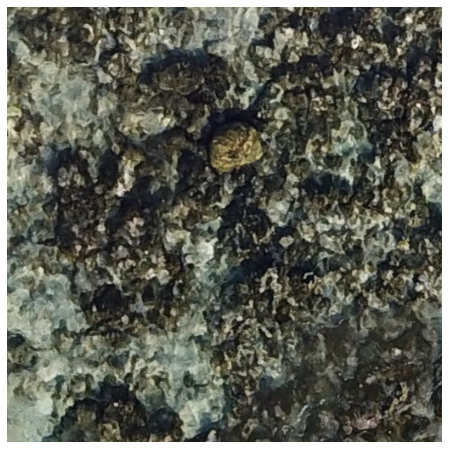

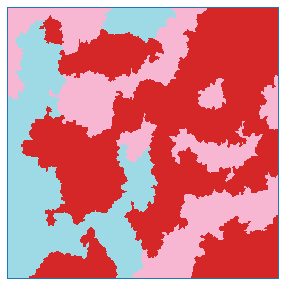

In [12]:
r_index = random.randint(0, len(fnames)-1)
#show some data
img_f = fnames[r_index]
img = open_image(img_f)
img.show(figsize=(8,8))

#show mask
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

#sr_size=np.array(img.shape[1:])
img.data

In [13]:
src_size = np.array(mask.shape[1:])
print(mask)
src_size,mask.data

print('Size: {}'.format(src_size))
t = mask.data
a = t.reshape(1, -1).squeeze()
n = to_np(a)
u = []
for i in n:
  if i not in u:
    u.append(i)
print(sorted(u))
len(u)

ImageSegment (1, 512, 512)
Size: [512 512]
[0, 1, 2, 3]


4

In [14]:
codes = np.array(['nodata',
         'coral', 
         'rocks', 
         'rubble', 
         'shallow water/sand', 
         'waves'])

In [15]:
bs = 2

In [16]:
data = (SegmentationItemList.from_folder(path/'trainData')
       #.split_by_folder(train=train, valid=path/'aug/valData') #splitting data by folder (make separate validation set)
       #.split_none()                                           #do not split data
       .split_by_rand_pct(0.25)                                  #split random -> put one of these on
       .label_from_func(get_y_fn, classes=codes)
       #.transform()                 #extra random transformations on 10% of the dataset
       .databunch(bs=bs).normalize())
       #.normalize())                                            #can be normalized on imagenetstats

In [17]:
#add test set
test_data = ImageList.from_folder(path/'test')

test_data[200]
data.add_test(test_data)

In [18]:
data

ImageDataBunch;

Train: LabelList (81 items)
x: SegmentationItemList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: SegmentationLabelList
ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512)
Path: /content/drive/My Drive/Master/Data/aug/trainData;

Valid: LabelList (26 items)
x: SegmentationItemList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: SegmentationLabelList
ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512)
Path: /content/drive/My Drive/Master/Data/aug/trainData;

Test: LabelList (410 items)
x: SegmentationItemList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: EmptyLabelList
,,,,
Path: /content/drive/My Drive/Master/Data/aug/trainData

In [19]:
print(data.classes)

['nodata' 'coral' 'rocks' 'rubble' 'shallow water/sand' 'waves']


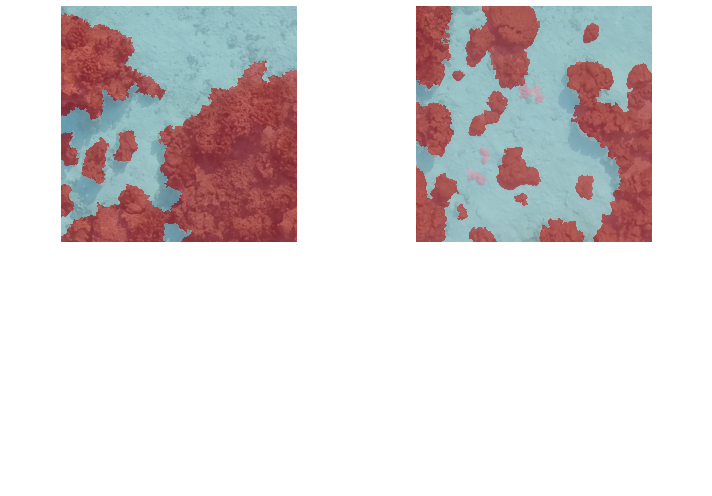

In [20]:
data.show_batch(2, figsize=(10,7))

In [21]:
#https://forums.fast.ai/t/create-databunch-with-multiple-segmentation-mask-as-label/53643/21
#custom accuracy class, otherwise the learner does not work due to tensor size errors.
def cust_accuracy(input:Tensor, targs:Tensor)->Rank0Tensor:
    "Computes accuracy with `targs` when `input` is bs * n_classes."
    n = targs.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    targs = targs.view(n,-1)
    return (input==targs).float().mean()

In [23]:
#https://forums.fast.ai/t/multi-class-semantic-segmentation-metrics-and-accuracy/74665/3
# Return Jaccard index, or Intersection over Union (IoU) value
def IoU(preds:Tensor, targs:Tensor, eps:float=1e-8):
    """Computes the Jaccard loss, a.k.a the IoU loss.
    Notes: [Batch size,Num classes,Height,Width]
    Args:
        targs: a tensor of shape [B, H, W] or [B, 1, H, W].
        preds: a tensor of shape [B, C, H, W]. Corresponds to
            the raw output or logits of the model. (prediction)
        eps: added to the denominator for numerical stability.
    Returns:
        iou: the average class intersection over union value 
             for multi-class image segmentation
    """
    num_classes = preds.shape[1]
    
    # Single class segmentation?
    if num_classes == 1:
        true_1_hot = torch.eye(num_classes + 1)[targs.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot_f = true_1_hot[:, 0:1, :, :]
        true_1_hot_s = true_1_hot[:, 1:2, :, :]
        true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
        pos_prob = torch.sigmoid(preds)
        neg_prob = 1 - pos_prob
        probas = torch.cat([pos_prob, neg_prob], dim=1)
        
    # Multi-class segmentation
    else:
        # Convert target to one-hot encoding
        # true_1_hot = torch.eye(num_classes)[torch.squeeze(targs,1)]
        true_1_hot = torch.eye(num_classes)[targs.squeeze(1)]
        
        # Permute [B,H,W,C] to [B,C,H,W]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        
        # Take softmax along class dimension; all class probs add to 1 (per pixel)
        probas = F.softmax(preds, dim=1)
        
    true_1_hot = true_1_hot.type(preds.type())
    
    # Sum probabilities by class and across batch images
    dims = (0,) + tuple(range(2, targs.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims) # [class0,class1,class2,...]
    cardinality = torch.sum(probas + true_1_hot, dims)  # [class0,class1,class2,...]
    union = cardinality - intersection
    iou = (intersection / (union + eps)).mean()   # find mean of class IoU values
    return iou

In [24]:
wd=0.01
learn = unet_learner(data, models.resnet34, 
                     metrics=[cust_accuracy, IoU],
                     wd=wd) 
                    # loss_func = nn.CrossEntropyLossFlat())  #loss function compatible in fastai 2 however, not sure how to implement it now
                     #bottle=True)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


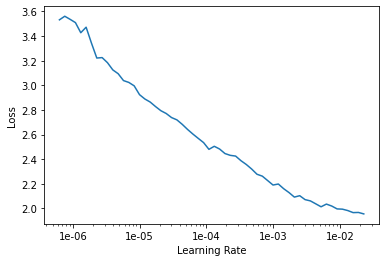

In [25]:
lr_find(learn)
learn.recorder.plot()

In [26]:
#chose best lr from plot
lr=5e-4

In [27]:
learn.fit_one_cycle(5, slice(lr))
#if this worked fine; no weird numbers and nans, tweaking can beglearnin

epoch,train_loss,valid_loss,cust_accuracy,IoU,time
0,1.673891,1.304965,0.447651,0.119423,00:24
1,1.337494,1.238178,0.519366,0.172150,00:18
2,1.192031,1.114192,0.544220,0.170202,00:18
3,1.095471,1.001748,0.557064,0.216944,00:18
4,1.034435,0.989523,0.579531,0.226592,00:18


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: UserWarning: Mixed memory format inputs detected while calling the operator. The operator will output contiguous tensor even if some of the inputs are in channels_last format. (Triggered internally at  /pytorch/aten/src/ATen/native/TensorIterator.cpp:918.)


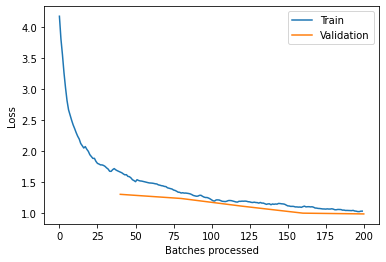

In [28]:
learn.recorder.plot_losses()

In [29]:
lrs = slice(lr/100,lr)
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,cust_accuracy,IoU,time
0,1.007091,1.038047,0.558919,0.228410,00:18
1,1.041305,1.011293,0.574097,0.260562,00:18
2,1.056856,1.043244,0.567452,0.265958,00:18
3,1.002376,0.936671,0.609020,0.307649,00:18
4,0.955967,0.922600,0.611406,0.319693,00:18


In [30]:
learn.save('stage-1')

In [31]:
learn.load('stage-1');

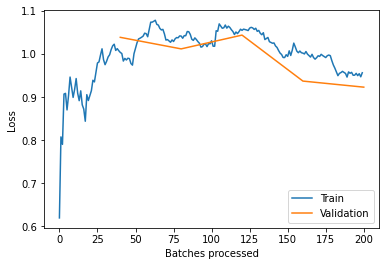

In [32]:
learn.recorder.plot_losses()

In [33]:
learn.unfreeze()

In [34]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,cust_accuracy,IoU,time
0,0.913624,0.902974,0.615289,0.329322,00:19
1,0.905400,0.887091,0.621794,0.347161,00:19
2,0.877902,0.844020,0.653536,0.337498,00:19
3,0.876926,0.863334,0.619929,0.369267,00:19
4,0.873452,1.025238,0.584023,0.316490,00:19
5,0.885771,0.847504,0.663463,0.372940,00:19
6,0.851768,1.042775,0.683267,0.394211,00:19
7,0.867384,0.783348,0.700568,0.388782,00:19
8,0.805923,0.820555,0.663615,0.406430,00:19
9,0.759389,0.798833,0.670277,0.388878,00:19


In [35]:
learn.save('stage-2');

In [36]:
learn.load('stage-2');

In [37]:
learn.fit_one_cycle(5, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,cust_accuracy,IoU,time
0,0.510914,0.722548,0.705822,0.448248,00:19
1,0.513512,0.680736,0.738499,0.439345,00:19
2,0.520955,0.752160,0.694690,0.450423,00:18
3,0.573277,0.757379,0.697502,0.410228,00:18
4,0.529829,0.774352,0.696022,0.451535,00:19


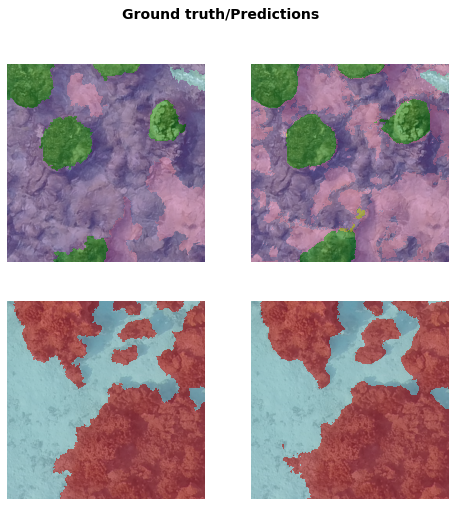

In [38]:
learn.show_results()

In [39]:
valids =learn.get_preds(ds_type = DatasetType.Valid)
valids[0].shape

torch.Size([26, 6, 512, 512])

array([[0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 1, 1, 1, ..., 2, 2, 2, 0],
       [0, 1, 1, 1, ..., 2, 2, 2, 0],
       [0, 1, 1, 1, ..., 2, 2, 2, 0],
       ...,
       [0, 1, 1, 1, ..., 1, 1, 1, 0],
       [0, 1, 1, 1, ..., 1, 1, 1, 0],
       [0, 5, 1, 1, ..., 1, 1, 1, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0]])

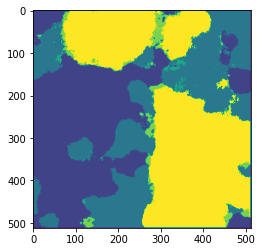

In [40]:
predicted_masks = np.argmax(valids[0],axis=1)
for i in range(len(predicted_masks)):
  Mask = (to_np(predicted_masks[i]))
  plt.imshow(Mask)

Mask

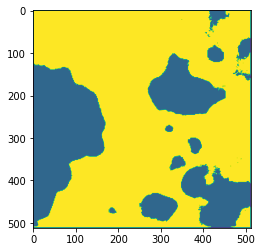

In [41]:
pred_v = valids[0][10]
pred_argmax = pred_v.argmax(dim=0)
plt.imshow(pred_argmax)

In [ ]:
ground_truth = []
classified = []

for i in range (len(learn.data.valid_ds)):
    ground_truth.append(data.valid_ds[i][1])
    pred_v = valids[0][i]
    pred_argmax = pred_v.argmax(dim=0)
    classified.append(pred_argmax)

In [43]:
#make custom function to make a confusion matrix
#for now, build in functions do not work
#import sklearn
#from sklearn.metrics import multilabel_confusion_matrix
#labels = ['0', '2', '1', '3','4','5'] #if string_type else" [0, 2, 1, 3, 4, 5]
#sklearn.metrics.multilabel_confusion_matrix(ground_truth, classified, labels=labels)

In [42]:
#When happy with the results, try them on the test set
test_preds=learn.get_preds(ds_type = DatasetType.Test)

In [45]:
#https://forums.fast.ai/t/get-the-filenames-of-the-data-in-the-test-set-in-the-order-theyre-predicted/46056/6
#fast.ai feeds databunches the order of test data randomly, so assign right filenames with the right maskmask
datasetIndex = []
num = len(learn.data.test_ds)

for i in range(num):
    datasetIndex.append(str(learn.data.test_ds.items[i]).split('/')[-1])

In [46]:
datasetIndex[1]

'tile_0220.png'

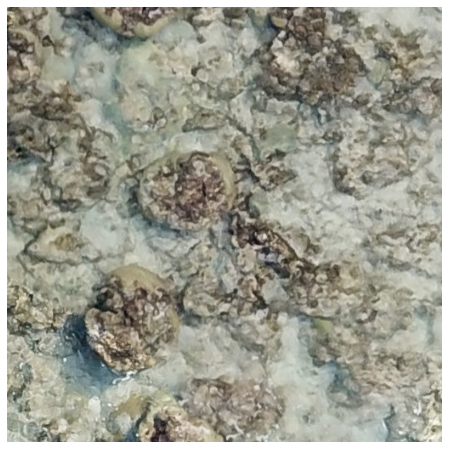

In [47]:
testnames = get_image_files(path/'test')
#show some data
img_t = testnames[1]
img = open_image(img_t)
img.show(figsize=(8,8))

In [48]:
#https://forums.fast.ai/t/saving-segmentation-masks-tutorial/62898
#followed this tutorial for saving the masks
test_preds[0].shape

torch.Size([410, 6, 512, 512])

In [49]:
pred_1 = test_preds[0][1]
pred_argmax = pred_1.argmax(dim=0)

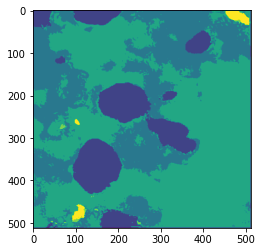

In [50]:
plt.imshow(pred_argmax)

In [51]:
#saving masks of testset
for i in range (0,410):
  pred_1 = test_preds[0][i]
  pred_argmax = pred_1.argmax(dim=0)
  pred_argmax = pred_argmax.numpy()
  rescaled = (255.0/pred_argmax.max() * (pred_argmax - pred_argmax.min())).astype(np.uint8)
  im = Img.fromarray(rescaled)

  im.save(str(path) + '/results/' + datasetIndex[i][:-4]+'.png')

